## Import libraries

In [7]:
import sys
import random

from pathlib import Path

import numpy as np
import pandas as pd

import networkx as nx

import matplotlib.pyplot as plt

DIR_PATH = Path.cwd().parent
sys.path.append(str(DIR_PATH))

from src.dataset.loader import read_rdata

# reload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Fix seed

In [34]:
seed = 42
random.seed(seed)   
np.random.seed(seed)

### Useful variables

In [2]:
DATA_BASE = DIR_PATH / 'data/raw/'
BALANCED_PATH = DATA_BASE / 'sim_data_balanced.RData'
UNBALANCED_PATH = DATA_BASE / 'sim_data_unbalanced.RData'

In [3]:
Adj_matrices_balanced, data_balanced = read_rdata(BALANCED_PATH)

In [4]:
Adj_matrices_balanced[0].shape, data_balanced.shape

((20, 20), (500, 23))

In [5]:
G=nx.from_numpy_array(Adj_matrices_balanced[0])

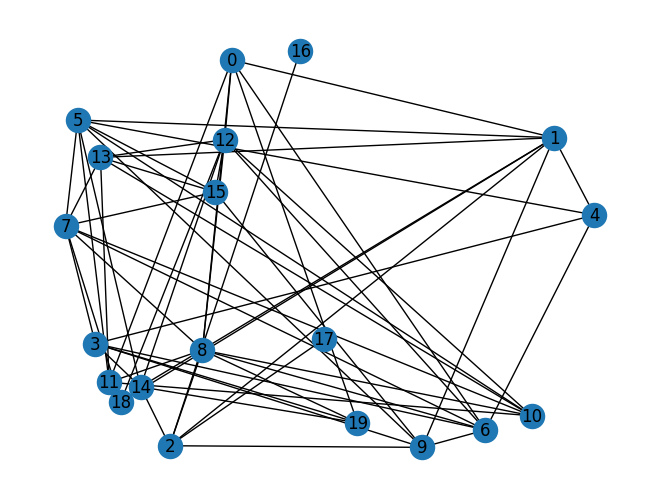

In [54]:
nx.draw(G, with_labels=True)